# Tutorial Part 2 -- Run BuDDI

This notebook is Part 2/2 of a BuDDI analysis. This assumes that you have already done all the steps in Tutorial Part 1.

This analysis is the same as the "liver" analysis in the manuscript.

Data format requirements for this step:
- We need the pseudobulk data
- We need the processed real bulk data
- We need the CIBERSORTx genes that were found to be cell-type specific, if you don't have this, code to generate the input files required by CIBERSORTx are added below. 
  
We do not run a hyperparameter search in this notebook, we just use the hyperparameters from the manuscript.


# **Imports**

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/demo_data/augmented_liver_data/"
bulk_aug_data_path = f"{os.getcwd()}/demo_data/bulk_data/"
res_data_path = f"{os.getcwd()}/demo_data/BuDDI_results/"



cibersort_path = f"{os.getcwd()}/demo_data/cibersort_liver/"


cibersort_genes_path = (f"{os.getcwd()}/demo_data/cibersort_liver/" +
                        "CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt")

# we use 7000 features (genes) as input
# in experiments (data not shown in manuscript) we
# found this to perform well in multiple datasets
# and train fast
num_genes = 7000

exp_id = "all-liver"

# this is true if you need to write out the input files for CIBERSORTx
# because you don't have cibersort_genes_path
RUN_CIBERSORT_GENES = False 


# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8


# number of patients/domains/samples expected
n_tot_samples = 51 # 51 bulk and single cell samples

# number of drugs (in this case sexes used for prediction)
# one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
# get the info for CIBERSORT for generating the union_genes

if RUN_CIBERSORT_GENES:
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, "1-M-63", "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    # now we transpose
    pseudobulks_df = pseudobulks_df.transpose()
    pseudobulks_df.columns = range(pseudobulks_df.shape[1])

    # now write it out
    sc_preprocess.write_cs_bp_files(cibersort_path, exp_id, sig_df, pseudobulks_df)



In [5]:
in_name = "liver_bulk_processed"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)


# now get the sc ref training data


X_concat = None
Y_concat = None
meta_concat = None

# read in male first
curr_samp = '30-M-5'
pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
pseudobulks_df.columns = gene_df
X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df

# now read in female
curr_samp = '18-F-51'
pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
pseudobulks_df.columns = gene_df
X_concat = pd.concat([X_concat, pseudobulks_df])
Y_concat = pd.concat([Y_concat, prop_df])
meta_concat = pd.concat([meta_concat, metadata_df])



# read in the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)


# put the reference single-cell and real bulk together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(15)]]) ## stop gap for now, we just add random cell type labels
meta_df = pd.concat([meta_concat, real_bulk_meta_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now, we just add random cell type labels
meta_df = pd.concat([meta_concat, real_bulk_meta_df])



/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_22355/2631356690.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_22355/2631356690.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_22355/2631356690.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

# Define indices and set-up metadata

In [6]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)

# get indices for reference later
idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]

# get the highest cell-type proportions
Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6453)[-6453:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]


# compare our variable genes with cibersort defined genes

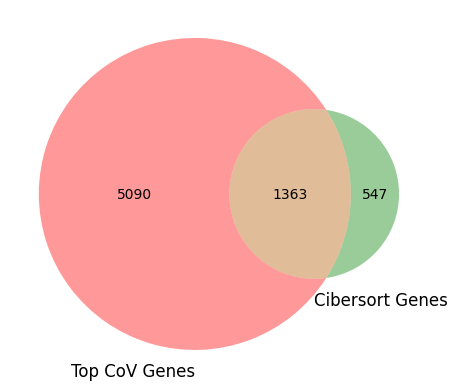

In [7]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [8]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

# Normalize data

In [9]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


# Plot all data

In the plot below, we plot the pseudobulk and real bulk data. Each plot will have a different coloration in order to highlight the different confounders present in the data.
In the first plot, it is colored by sample ID, but since there are 51 real bulk samples, we hide the legend.
The final plot is colored by the cell-type that has the highest proportion in the pseudobulk. 
For the bulk data, this is a random cell-type.

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3649 samples in 0.101s...
[t-SNE] Computed neighbors for 3649 samples in 1.344s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3649
[t-SNE] Computed conditional probabilities for sample 2000 / 3649
[t-SNE] Computed conditional probabilities for sample 3000 / 3649
[t-SNE] Computed conditional probabilities for sample 3649 / 3649
[t-SNE] Mean sigma: 1.150568
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.429817
[t-SNE] KL divergence after 500 iterations: 1.059457
(3649, 2)
(3649, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_22355/1273205358.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


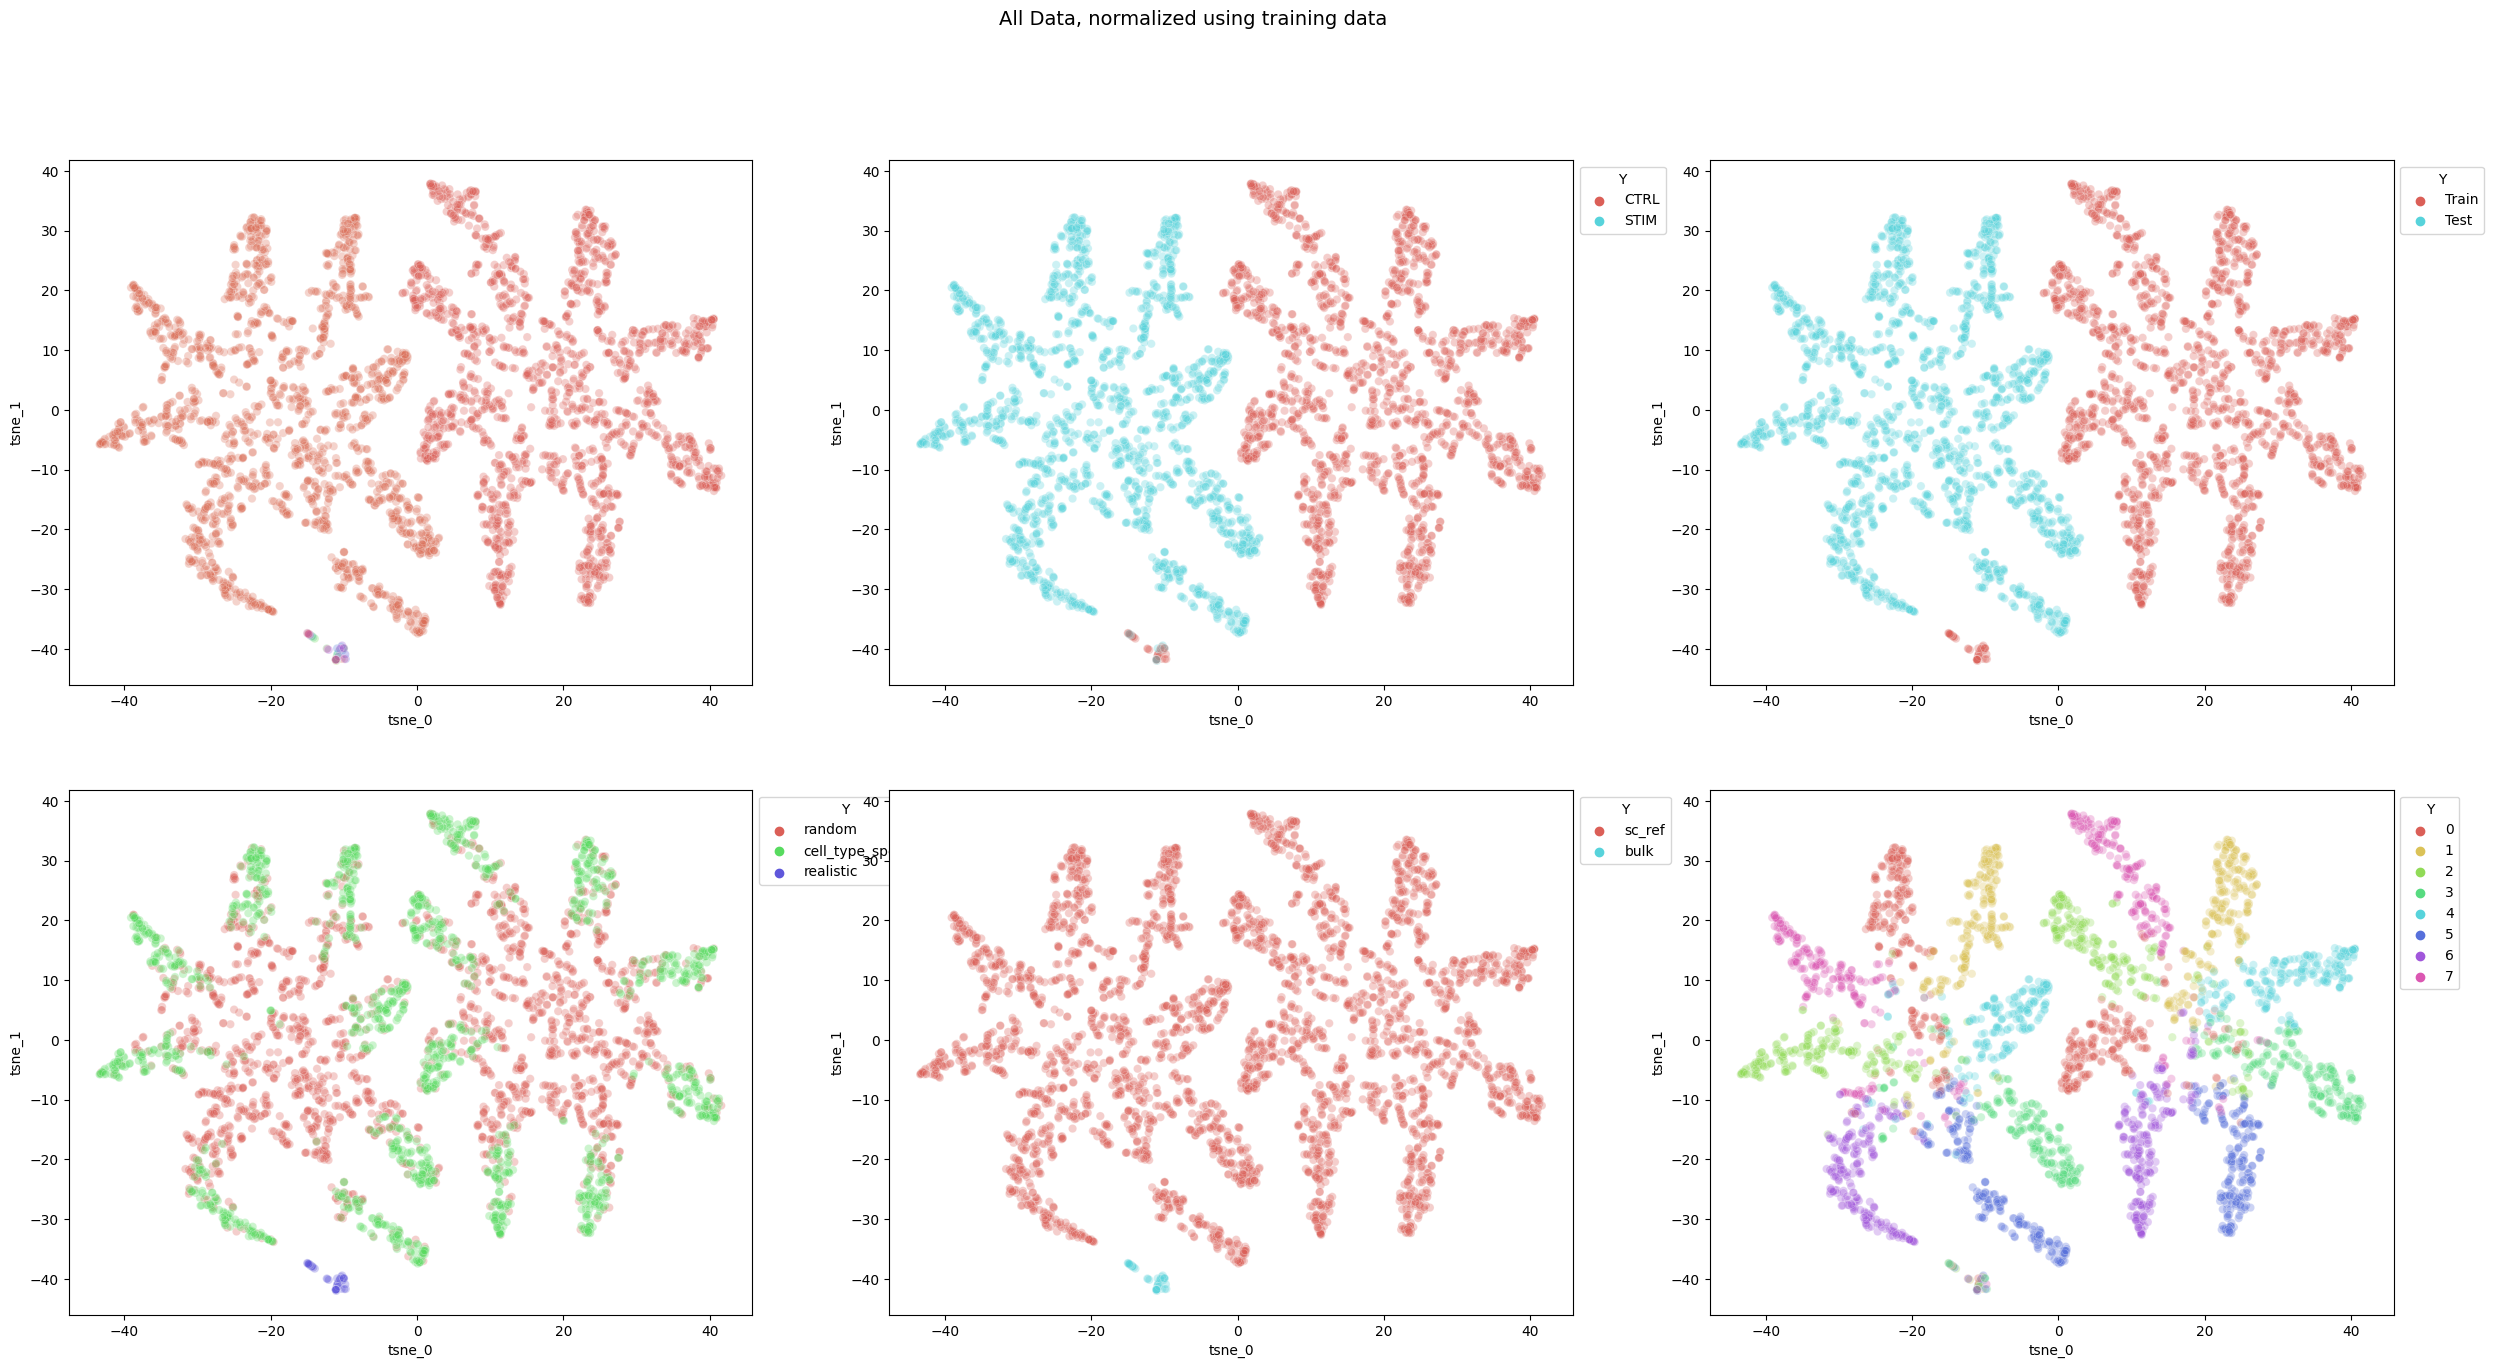

In [10]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Run BuDDI**

2023-09-28 16:58:56.204795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-28 16:58:56.221119: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_out/bias/Assign' id:372 op device:{requested: '', assigned: ''} def:{{{node cls_out/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](cls_out/bias, cls_out/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-28 16:58:56.446894: W tensorflow/c/c_api.cc:304] Operation '{name:'z_samp_slack/truediv/y' id:387 op device:{requested: '', assigned: ''} def:{{{node z_samp_slack/truediv/y}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 2>]()}}' was changed by setting attribute afte

test_size_samp: 500
train_size_samp: 1500


2023-09-28 16:58:57.099004: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/decoder_h1/kernel/v/Assign' id:2432 op device:{requested: '', assigned: ''} def:{{{node training/Adam/decoder_h1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/decoder_h1/kernel/v, training/Adam/decoder_h1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-28 16:58:57.992577: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/AddN' id:1183 op device:{requested: '', assigned: ''} def:{{{node loss_1/AddN}} = AddN[N=4, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul, loss_1/mul_1, loss_1/mul_2, loss_1/mul_3)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

Elapsed:  300.89674401283264
Epoch:  199
INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_known_prop_vae/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_known_prop_vae/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_encoder_unlab/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_encoder_unlab/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_encoder_lab/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_encoder_lab/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_decoder/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_decoder/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_classifier/assets


INFO:tensorflow:Assets written to: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/tutorial/demo_data/BuDDI_results//demo_model_classifier/assets


2023-09-28 17:04:06.124582: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_30' id:5201 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_30}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_4, Identity_634)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2023-09-28 17:04:06.948351: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_64' id:5604 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_64}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_21, Identity_668)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2023-09-28 17:04:07.271688: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_69' id:5760 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_69}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_25, Identity_673)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2023-09-28 17:04:07.565955: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_73' id:5845 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_73}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_27, Identity_677)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


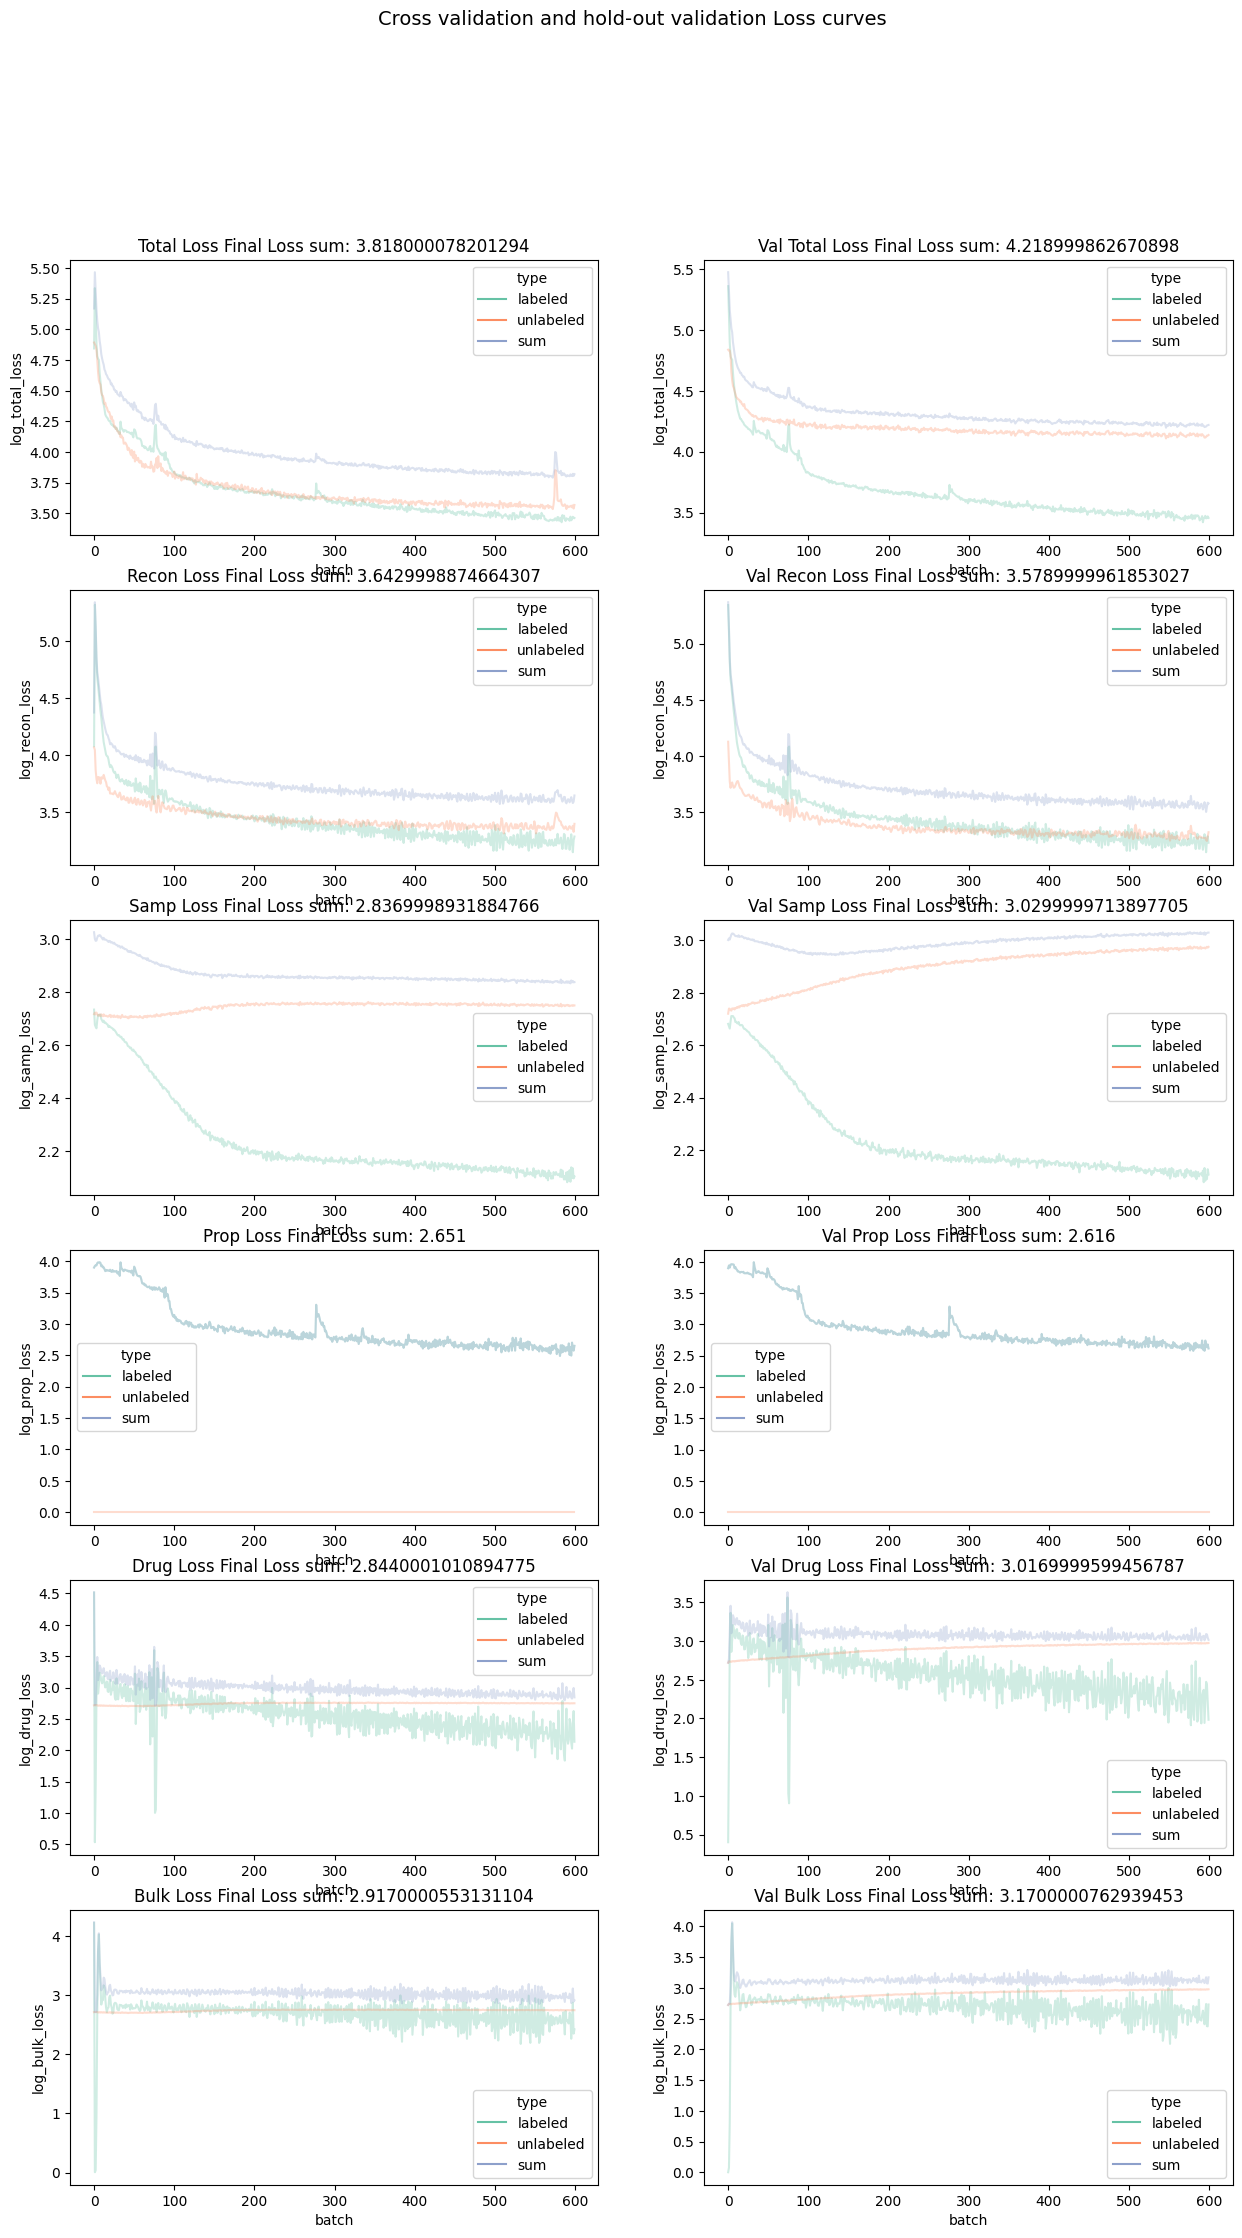

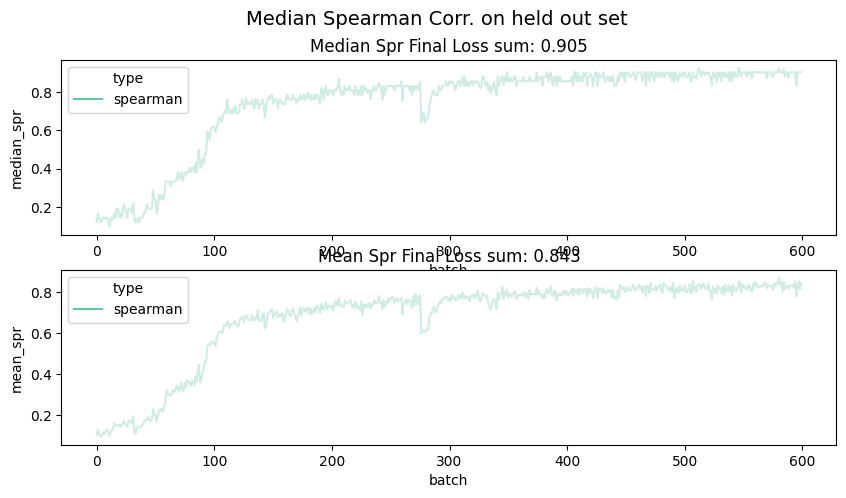

In [11]:
curr_n_epoch=200
curr_wt = 100

# set up all the parameters
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

# run buddi
exp_id = "demo_model"
res = buddi.train_buddi(res_data_path, exp_id, use_buddi4=True, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

# read in the model
res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_classifier")



## visualize latent spaces

In [12]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

# get the training pseudobulks
idx_tmp_bulk = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type == "realistic"))[0]
idx_tmp_bulk = np.random.choice(idx_tmp_bulk, 500, replace=True)

# get the real bulks
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type != "realistic"))[0]
idx_tmp = np.random.choice(idx_tmp, 500, replace=True)

# concatenate so we have them all
idx_tmp = np.concatenate((idx_tmp, idx_tmp_bulk))

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]


### plot data

Here, we plot the latent spaces of BuDDI on Tabula Muris Senis dataset. Each column is a latent space and each row is colored by a source of variation. The second row is colored by sample ID, but due to the number of bulk samples, we omit the sample ID legend.
First we examined whether or not BuDDI separated the sources of variability in this highly correlated dataset. We visually found that each latent space was specific to its target source of variability. Importantly, we observed a clear separation between the cell type and the sex, the two latent factors required predict cell-type-specific sex differences. However, some entanglement remained between the slack and cell-type latent spaces. 

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-09-28 17:04:08.826164: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack/add/z_samp_slack/add' id:5296 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack/add/z_samp_slack/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dependencies=true](mu_slack_1/BiasAdd, tf_op_layer_z_samp_slack/mul/z_samp_slack/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-28 17:04:09.044395: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_out_1/Softmax' 

(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


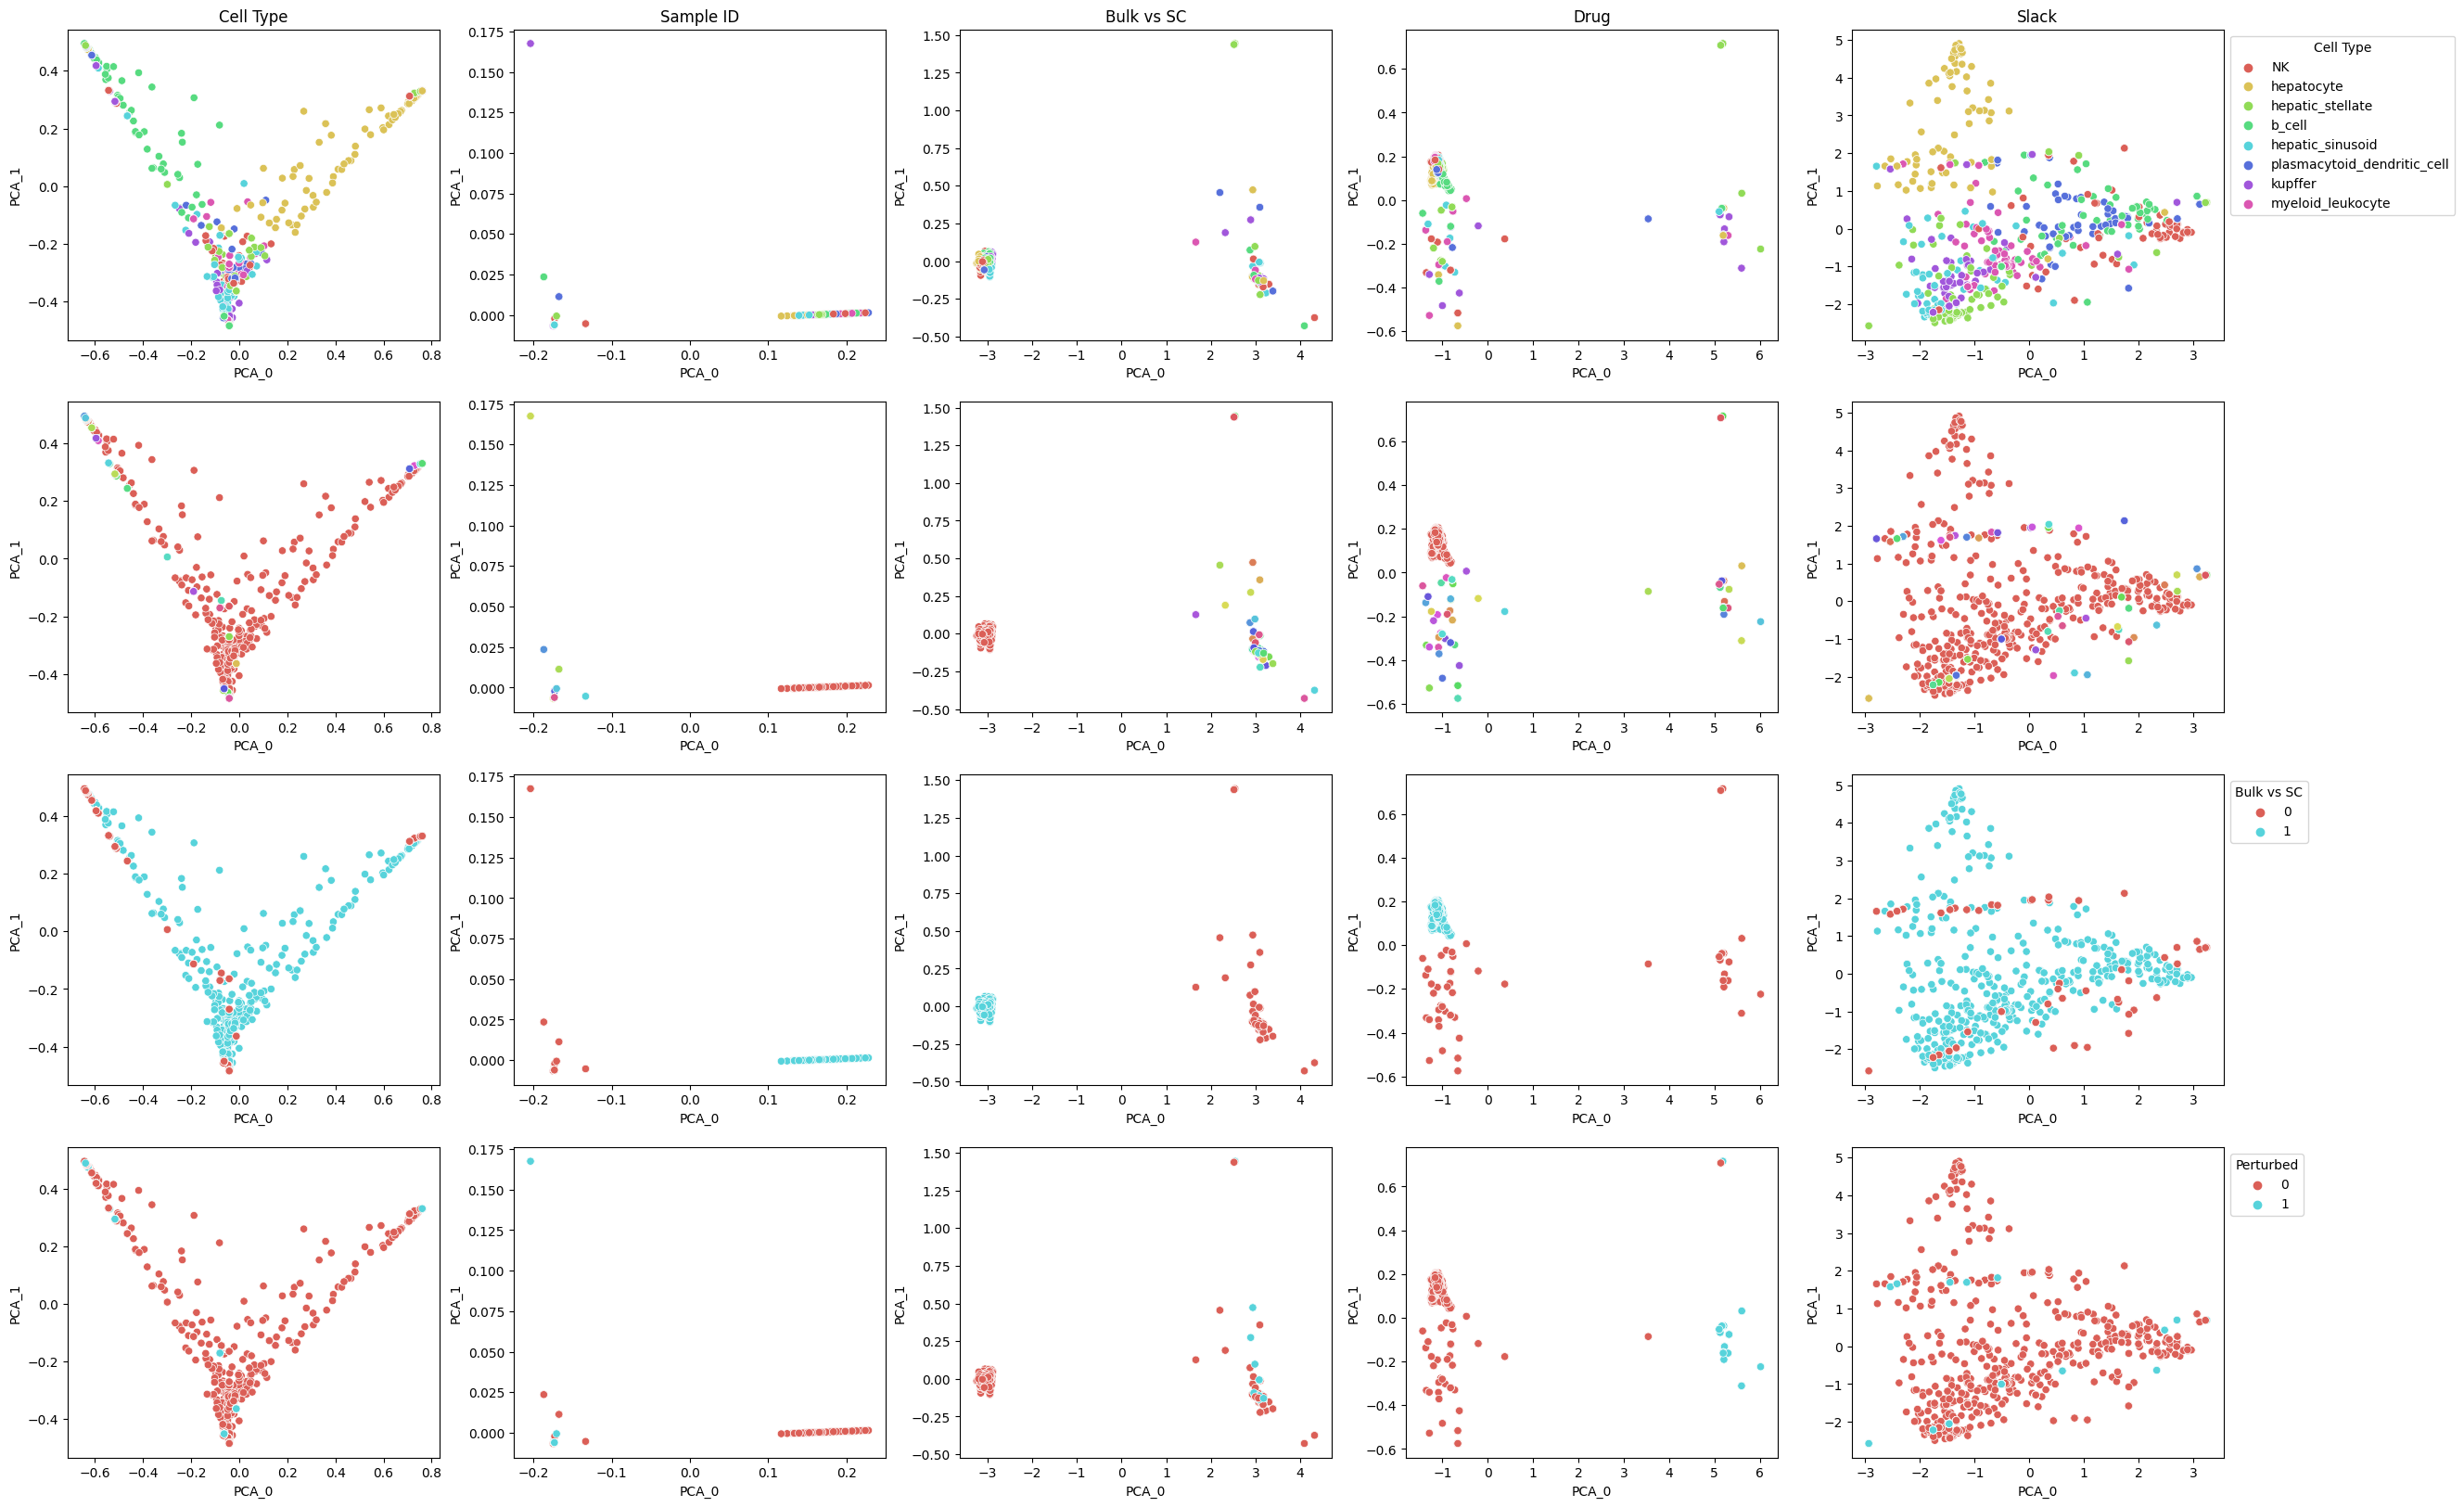

In [13]:

res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True, hide_sample_ids=True)

## visualize reconstruction

### subset data

In [14]:
# take all training data

recon_idx = np.where(np.logical_and(meta_df.cell_prop_type == "cell_type_specific", meta_df.isTraining == "Test"))[0]
recon_idx = np.where(recon_idx)[0]
recon_idx = np.random.choice(recon_idx, 1000, replace=True)

# subset our data

meta_temp = meta_df.iloc[recon_idx]

X_temp = np.copy(X_full[recon_idx])

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_full.columns[Y_temp]


label_temp = np.copy(Label_full[recon_idx])
label_temp = index_label[label_temp]

perturb_temp = Drug_full[recon_idx]




### plot data

Here, we wanted to show how well our model can reconstruct the data. We plot the reconstructed data on an unseen (female) test set and show it reconstructs the pseudobulk variability very effectively.
The first plot is colored by cell type, then sample ID (there is only one sample), then by whether it is reconstructed or the original input data.

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-09-28 17:04:12.918727: W tensorflow/c/c_api.cc:304] Operation '{name:'decoder_out_3/Sigmoid' id:5770 op device:{requested: '', assigned: ''} def:{{{node decoder_out_3/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder_out_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


(2000, 2)
(2000, 2)


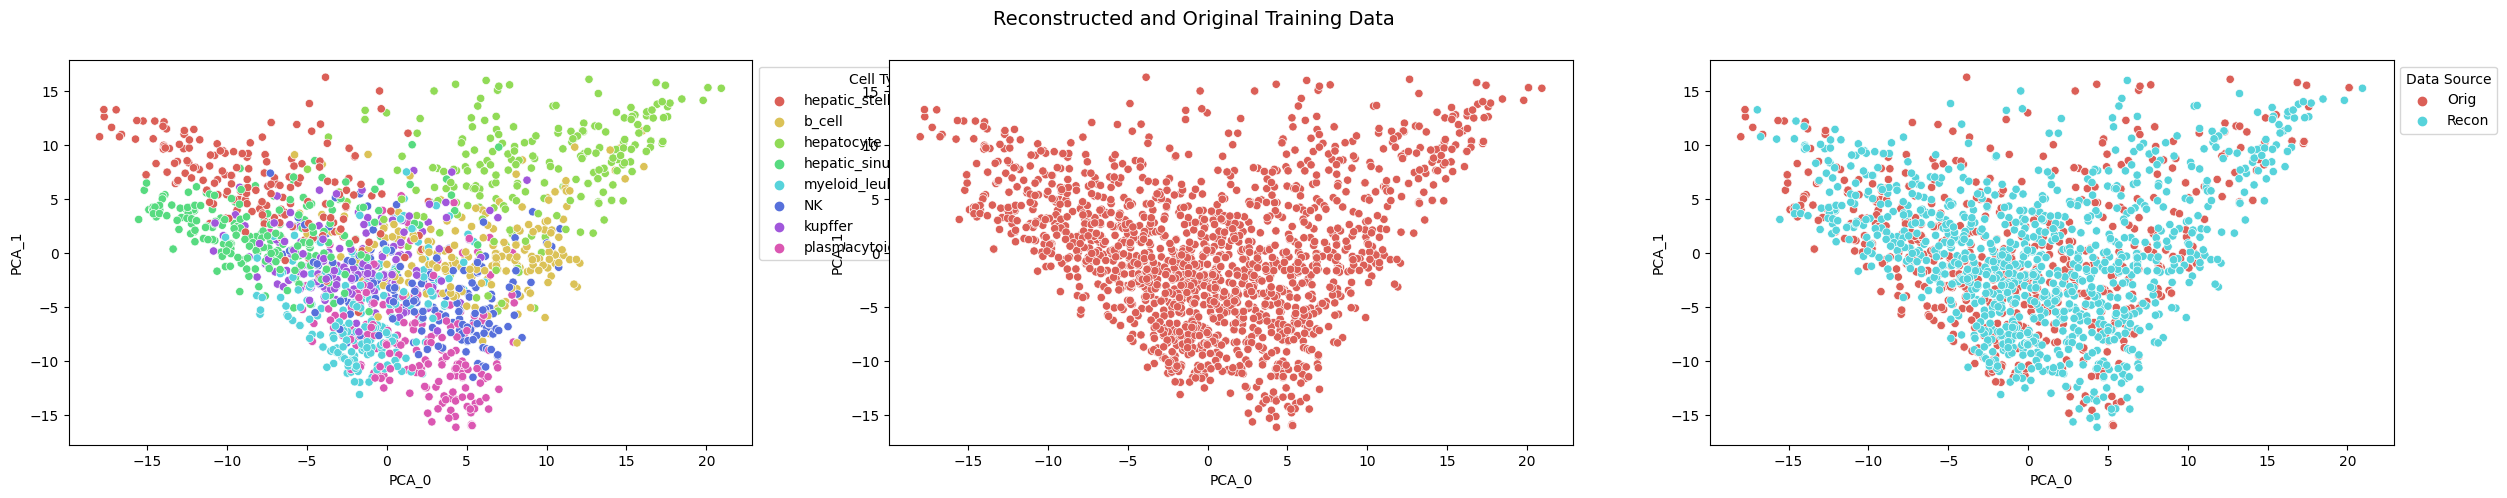

In [15]:
res1_recon_plot = buddi.plot_reconstruction_buddi(res1_enc_unlab, res1_classifier, res1_dec,
        X_temp, Y_temp, label_temp, perturb_temp, 
        batch_size=500, use_buddi4=True)